# C rate dependence
Peter Attia

This notebook analyzes the C rate dependence of the first cycle reactions in carbon black.

Note that this notebook has two differences in nomenclature relative to the paper:
- "Constant-current" is used instead of "one-step"; "multistep current" is used instead of "two-step"
- "1st-lithiation" is used instead of "formation"

In [1]:
import re
from pathlib import Path
import numpy as np
import pandas as pd

import scipy.stats
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

from scipy.constants import R
from scipy.constants import physical_constants
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rcParams
from matplotlib.ticker import AutoMinorLocator
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.legend_handler import HandlerBase

Set plotting settings:

In [2]:
fig_width = 3.25 #ECS spec is 3.25" width
fig_height = (3/4)*fig_width # standard ratio
rcParams['lines.markersize'] = 5
rcParams['lines.linewidth'] = 1.0
rcParams['font.size'] = 7
rcParams['legend.fontsize'] = 7
rcParams['legend.frameon'] = False
rcParams['font.sans-serif'] = 'Arial'
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Arial'
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

figpath = Path.cwd().parent / 'figures'

## Load data

Metadata:

In [3]:
metadata = pd.read_csv('masses.csv')
metadata

,File name,Mass (mg),C rate
0,cellA_Cover100_split_CA1,0.977,0.010000
1,cellA_Cover100_CC4,0.548,0.010000
2,cellC_Cover30_split_CC5,0.914,0.033333
3,cellD_Cover30_CC6,0.845,0.033333
4,cellA_Cover10_CC7,0.776,0.100000
5,cellE_Cover3_split_CC8,0.809,0.333333
6,cellC_Cover3_CF6,0.583,0.333333
7,cellG_1C_split_CD3,0.468,1.000000
8,cellM_1C_CD5,0.743,1.000000
9,cellF_3C_split_CF6,1.011,3.000000


## Constant current data
Raw data:

In [4]:
files_constcurr = list((Path.cwd() / 'constant current data').glob('*.txt'))
files_constcurr

[PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellA_Cover100_CC4.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellJ_3C_CD8.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellM_1C_CD5.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellC_Cover3_CF6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellD_Cover30_CC6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellC_10C_CF3.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/constant current data/cellA_Cover10_CC7.txt')]

Parse and process:

In [5]:
all_data_constcurr = {}

for file in files_constcurr:
    
    sub_dict = {}
    
    # C rate parsing
    C_rate = int(re.findall(r'\d+', file.name.split('_')[1])[0])
    C_rate_string = file.name.split('_')[1].replace('over', '/')
    
    if 'Cover' in file.name:
        C_rate = 1 / C_rate
    
    # Logging
    print(f'{file.stem}: {C_rate}, {C_rate_string}')
    
    # Load data
    data = np.loadtxt(file, skiprows=1)
    
    # Get mass
    mass = metadata[metadata['File name'] == file.stem]['Mass (mg)'].iloc[0] / 1000 # mg -> g
    
    # Normalize capacity by mass
    data[:, 2] = data[:, 2] / mass # mAh -> mAh/g
    
    # Index different cycle numbers
    first_lith_idx = np.where(data[:, 0] == 1)[0][0]
    second_cycle_idx = np.where(data[:, 0] == 2)[0][0]
    second_lith_idx = first_lith_idx + np.where(data[first_lith_idx:second_cycle_idx, 1] == np.max(data[first_lith_idx:second_cycle_idx, 1]))[0][0]
    try:
        third_cycle_idx = np.where(data[:, 0] == 3)[0][0]
        third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:third_cycle_idx, 1] == np.max(data[second_cycle_idx:third_cycle_idx, 1]))[0][0]
        
        fourth_cycle_idx = np.where(data[:, 0] == 4)[0][0]
        fourth_lith_idx = third_cycle_idx + np.where(data[third_cycle_idx:fourth_cycle_idx, 1] == np.max(data[third_cycle_idx:fourth_cycle_idx, 1]))[0][0]

        fifth_cycle_idx = np.where(data[:, 0] == 5)[0][0]
        fifth_lith_idx = fourth_cycle_idx + np.where(data[fourth_cycle_idx:fifth_cycle_idx, 1] == np.max(data[fourth_cycle_idx:fifth_cycle_idx, 1]))[0][0]
        
        sixth_cycle_idx = np.where(data[:, 0] == 6)[0][0]
        sixth_lith_idx = fifth_cycle_idx + np.where(data[fifth_cycle_idx:sixth_cycle_idx, 1] == np.max(data[fifth_cycle_idx:sixth_cycle_idx, 1]))[0][0]
        
    except IndexError: # 10C data has only 2 cycles
        third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:, 1] == np.max(data[second_cycle_idx:, 1]))[0][0]
    
    # Extract (de)lith steps
    first_lith_data = data[:first_lith_idx]
    first_delith_data = data[first_lith_idx:second_lith_idx]
    second_lith_data = data[second_lith_idx:second_cycle_idx]
    second_delith_data = data[second_cycle_idx:third_lith_idx]
    third_lith_data = data[third_lith_idx:third_cycle_idx]
    third_delith_data = data[third_cycle_idx:fourth_lith_idx]
    fourth_lith_data = data[fourth_lith_idx:fourth_cycle_idx]
    fourth_delith_data = data[fourth_cycle_idx:fifth_lith_idx]
    fifth_lith_data = data[fifth_lith_idx:fifth_cycle_idx]
    fifth_delith_data = data[fifth_cycle_idx:sixth_lith_idx]

    # Get first-lithiation capacity above/below 0.5V
    idx_0pt5V = np.where(data[:, 1] < 0.5)[0][0]
    Qlith_cyc1_above0pt5 = np.max(first_lith_data[:idx_0pt5V])
    Qlith_cyc1_below0pt5 = np.max(first_lith_data) - Qlith_cyc1_above0pt5
    
    idx_0pt5V = np.where(first_delith_data[:, 1] > 0.5)[0][0]
    Qdelith_cyc1_below0pt5 = np.max(first_delith_data[:idx_0pt5V])
    
    print(f'Above-0.5 V capacity (lith1): {Qlith_cyc1_above0pt5:.2f} mAh/g')
    print(f'Below-0.5 V capacity (delith1): {Qdelith_cyc1_below0pt5:.2f} mAh/g')
    
    # Get first-lithiation time
    I = 200 * C_rate # 1C = 200 mAh/g
    tlith_cyc1 = np.max(first_lith_data) / I # t = Q/I; mAh/g / mA/g -> h
    
    # Get capacities for DeltaQ and CE
    Qlith_cyc2 = np.max(second_lith_data)
    Qdelith_cyc2 = np.max(second_delith_data)
    DeltaQ_1_vs_2 = np.max(first_lith_data) - Qlith_cyc2
    CE_cyc2 = 100 * Qdelith_cyc2 / Qlith_cyc2
    
    # Note: the C/10 data is cycled up to 2.0 V instead of 1.2 V.
    # Offset the capacity just in the SI plot of second cycle V vs Q
    if C_rate_string == 'C/10':
        second_lith_idx = np.where(data[second_lith_idx:second_cycle_idx][:,1] < 1.2)[0][0] + second_lith_idx
        second_lith_data = data[second_lith_idx:second_cycle_idx]
        second_lith_data[:, 2] = second_lith_data[:, 2] - data[second_lith_idx, 2]
    
    # Create dictionary    
    sub_dict['First lith data'] = first_lith_data
    sub_dict['First delith data'] = first_delith_data
    sub_dict['Second lith data'] = second_lith_data
    sub_dict['Second delith data'] = second_delith_data
    
    sub_dict['C rate'] = C_rate
    sub_dict['C rate string'] = C_rate_string
    sub_dict['1st lith capacity above 0.5V'] = Qlith_cyc1_above0pt5
    sub_dict['1st lith capacity below 0.5V'] = Qlith_cyc1_below0pt5
    sub_dict['1st delith capacity below 0.5V'] = Qdelith_cyc1_below0pt5
    sub_dict['1st lith time'] = tlith_cyc1
    sub_dict['First lith - second lith'] = DeltaQ_1_vs_2
    sub_dict['First lith + second lith'] = Qlith_cyc1_below0pt5 - Qdelith_cyc1_below0pt5 + Qlith_cyc2 - Qdelith_cyc2
    sub_dict['2nd cycle CE'] = CE_cyc2
    
    try:
        sub_dict['3rd cycle CE'] = 100 * np.max(third_delith_data) / np.max(third_lith_data)
        sub_dict['4th cycle CE'] = 100 * np.max(fourth_delith_data) / np.max(fourth_lith_data)
        sub_dict['5th cycle CE'] = 100 * np.max(fifth_delith_data) / np.max(fifth_lith_data)
        
    except:
        print('CE error')
    
    if C_rate_string != '10C':
        
        Q = first_lith_data[:,2]
        V = first_lith_data[:,1]
        
        # Filter and get dQ/dV
        Q_filt = savgol_filter(Q, 101, 1)
        V_filt = savgol_filter(V, 101, 1)
        dQdV = np.gradient(Q_filt, V_filt)

        # Get V_peak
        idx1pt2 = np.where(V_filt < 1.2)[0][0]
        idx0pt5 = np.where(V_filt < 0.5)[0][0]
        peak_idx, _ = find_peaks(-dQdV[idx1pt2:idx0pt5], distance=1e7)
        peak_idx = idx1pt2 + peak_idx[0]
        
        V_peak = V_filt[peak_idx]
        dQdV_peak = dQdV[peak_idx]
        
        sub_dict['V_filt'] = V_filt
        sub_dict['dQdV'] = dQdV
        sub_dict['V_peak'] = V_peak
        sub_dict['dQdV_peak'] = dQdV_peak
        
    # Append to main dictionary
    all_data_constcurr[file.stem] = sub_dict
    
    print()

cellA_Cover100_CC4: 0.01, C/100
Above-0.5 V capacity (lith1): 329.68 mAh/g
Below-0.5 V capacity (delith1): 151.80 mAh/g

cellJ_3C_CD8: 3, 3C
Above-0.5 V capacity (lith1): 162.14 mAh/g
Below-0.5 V capacity (delith1): 86.28 mAh/g

cellM_1C_CD5: 1, 1C
Above-0.5 V capacity (lith1): 181.22 mAh/g
Below-0.5 V capacity (delith1): 100.87 mAh/g

cellC_Cover3_CF6: 0.3333333333333333, C/3
Above-0.5 V capacity (lith1): 211.26 mAh/g
Below-0.5 V capacity (delith1): 121.51 mAh/g

cellD_Cover30_CC6: 0.03333333333333333, C/30
Above-0.5 V capacity (lith1): 255.33 mAh/g
Below-0.5 V capacity (delith1): 149.54 mAh/g

cellC_10C_CF3: 10, 10C
Above-0.5 V capacity (lith1): 37.88 mAh/g
Below-0.5 V capacity (delith1): 1.00 mAh/g
CE error

cellA_Cover10_CC7: 0.1, C/10
Above-0.5 V capacity (lith1): 228.05 mAh/g
Below-0.5 V capacity (delith1): 139.57 mAh/g



In [6]:
all_data_constcurr = {k: v for k, v in sorted(all_data_constcurr.items(), key=lambda item: item[1]['C rate'])}

Min/max V_peak:

In [7]:
for k, (key, value) in enumerate(all_data_constcurr.items()):
    if '10C' not in key:
        print(f"{key}: {value['V_peak']}")

cellA_Cover100_CC4: 1.0406326495049505
cellD_Cover30_CC6: 0.9779112938613862
cellA_Cover10_CC7: 0.9191045367326736
cellC_Cover3_CF6: 0.8239095846534654
cellM_1C_CD5: 0.7610608448514855
cellJ_3C_CD8: 0.6743408152475245


## Multistep data
Raw data:

In [8]:
files_multistep = list((Path.cwd() / 'multistep current data').glob('*.txt'))
files_multistep

[PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellC_Cover30_split_CC5.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellA_Cover100_split_CA1.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellK_10C_split_CF1.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellF_3C_split_CF6.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellE_Cover3_split_CC8.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellG_1C_split_CD3.txt'),
 PosixPath('/Users/peter/Documents/GitHub/first-cycle-SEI-on-carbon-black/c rate/multistep current data/cellA_Cover10_CC7.txt')]

Parse and process:

cellC_Cover30_split_CC5: 0.03333333333333333, C/30(0.5V)-C/10
Above-0.5 V capacity (lith1): 247.85 mAh/g
Below-0.5 V capacity (delith1): 135.23 mAh/g

cellA_Cover100_split_CA1: 0.01, C/100(0.5V)-C/10
Above-0.5 V capacity (lith1): 309.34 mAh/g
Below-0.5 V capacity (delith1): 145.82 mAh/g

cellK_10C_split_CF1: 10, 10C(0.5V)-C/10
Above-0.5 V capacity (lith1): 122.86 mAh/g
Below-0.5 V capacity (delith1): 136.65 mAh/g

cellF_3C_split_CF6: 3, 3C(0.5V)-C/10
Above-0.5 V capacity (lith1): 90.07 mAh/g
Below-0.5 V capacity (delith1): 128.28 mAh/g

cellE_Cover3_split_CC8: 0.3333333333333333, C/3(0.5V)-C/10
Above-0.5 V capacity (lith1): 215.56 mAh/g
Below-0.5 V capacity (delith1): 145.10 mAh/g

cellG_1C_split_CD3: 1, 1C(0.5V)-C/10
Above-0.5 V capacity (lith1): 184.28 mAh/g
Below-0.5 V capacity (delith1): 131.85 mAh/g

cellA_Cover10_CC7: 0.1, C/10
Above-0.5 V capacity (lith1): 227.88 mAh/g
Below-0.5 V capacity (delith1): 139.57 mAh/g



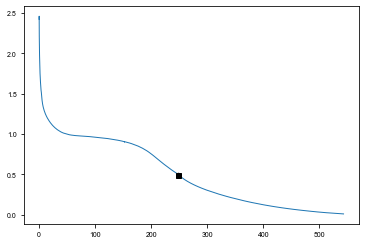

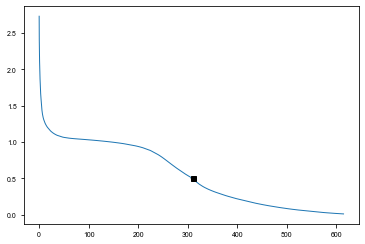

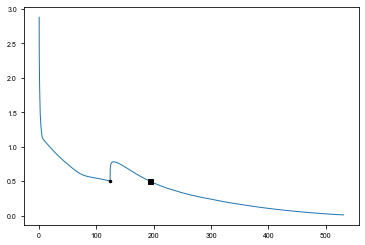

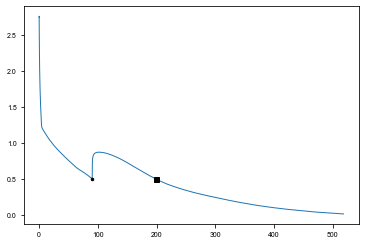

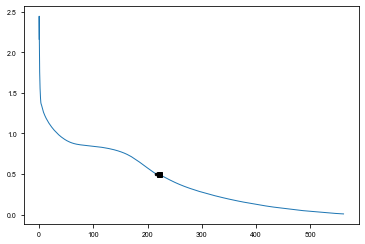

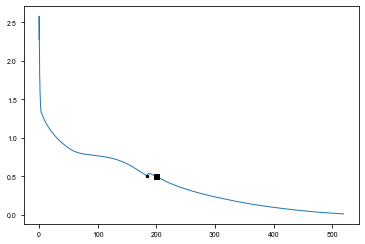

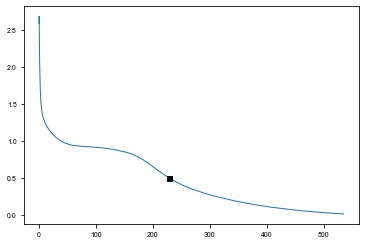

In [9]:
all_data_multistep = {}

for file in files_multistep:
    
    sub_dict = {}
    
    # C rate parsing
    C_rate = int(re.findall(r'\d+', file.name.split('_')[1])[0])
    C_rate_string = file.name.split('_')[1].replace('over', '/') + '(0.5V)-C/10'
    if C_rate_string == 'C/10(0.5V)-C/10':
        C_rate_string = 'C/10'
    
    if 'Cover' in file.name:
        C_rate = 1 / C_rate
    
    # Logging
    print(f'{file.stem}: {C_rate}, {C_rate_string}')
    
    # Load data
    data = np.loadtxt(file, skiprows=1)
    
    # Get mass
    mass = metadata[metadata['File name'] == file.stem]['Mass (mg)'].iloc[0] / 1000 # mg -> g
    
    # Normalize capacity by mass
    data[:, 2] = data[:, 2] / mass # mAh -> mAh/g
    
    # Index different cycle numbers
    first_lith_idx = np.where(data[:, 0] == 1)[0][0]
    second_cycle_idx = np.where(data[:, 0] == 2)[0][0]
    third_cycle_idx = np.where(data[:, 0] == 3)[0][0]
    second_lith_idx = first_lith_idx + np.where(data[first_lith_idx:second_cycle_idx, 1] == np.max(data[first_lith_idx:second_cycle_idx, 1]))[0][0]
    third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:third_cycle_idx, 1] == np.max(data[second_cycle_idx:third_cycle_idx, 1]))[0][0]
    
    try:
        fourth_cycle_idx = np.where(data[:, 0] == 4)[0][0]
        fourth_lith_idx = third_cycle_idx + np.where(data[third_cycle_idx:fourth_cycle_idx, 1] == np.max(data[third_cycle_idx:fourth_cycle_idx, 1]))[0][0]

        fifth_cycle_idx = np.where(data[:, 0] == 5)[0][0]
        fifth_lith_idx = fourth_cycle_idx + np.where(data[fourth_cycle_idx:fifth_cycle_idx, 1] == np.max(data[fourth_cycle_idx:fifth_cycle_idx, 1]))[0][0]
        
        sixth_cycle_idx = np.where(data[:, 0] == 6)[0][0]
        sixth_lith_idx = fifth_cycle_idx + np.where(data[fifth_cycle_idx:sixth_cycle_idx, 1] == np.max(data[fifth_cycle_idx:sixth_cycle_idx, 1]))[0][0]
        
    except IndexError: # 10C data has only 2 cycles
        third_lith_idx = second_cycle_idx + np.where(data[second_cycle_idx:, 1] == np.max(data[second_cycle_idx:, 1]))[0][0]
    
    # Extract (de)lith steps
    first_lith_data = data[:first_lith_idx]
    first_delith_data = data[first_lith_idx:second_lith_idx]
    second_lith_data = data[second_lith_idx:second_cycle_idx]
    second_delith_data = data[second_cycle_idx:third_lith_idx]
    third_lith_data = data[third_lith_idx:third_cycle_idx]
    third_delith_data = data[third_cycle_idx:fourth_lith_idx]
    fourth_lith_data = data[fourth_lith_idx:fourth_cycle_idx]
    fourth_delith_data = data[fourth_cycle_idx:fifth_lith_idx]
    fifth_lith_data = data[fifth_lith_idx:fifth_cycle_idx]
    fifth_delith_data = data[fifth_cycle_idx:sixth_lith_idx]
    
    # Get first-lithiation capacity above/below 0.5V
    # I exclude the capacity above 0.5 V *after* the overpotential relaxation
    idx_0pt5V_above = np.where(data[:, 1] < 0.501)[0][0]
    idx_0pt5V_below = np.where(data[:, 1] < 0.499)[0][0]
    Qlith_cyc1_above0pt5 = np.max(first_lith_data[:idx_0pt5V_above])
    Qlith_intermediate = first_lith_data[idx_0pt5V_below, 2] - first_lith_data[idx_0pt5V_above, 2]
    Qlith_cyc1_below0pt5 = np.max(first_lith_data) - Qlith_cyc1_above0pt5 - Qlith_intermediate
    
    idx_0pt5V = np.where(first_delith_data[:, 1] > 0.5)[0][0]
    Qdelith_cyc1_below0pt5 = np.max(first_delith_data[:idx_0pt5V])
    
    print(f'Above-0.5 V capacity (lith1): {Qlith_cyc1_above0pt5:.2f} mAh/g')
    print(f'Below-0.5 V capacity (delith1): {Qdelith_cyc1_below0pt5:.2f} mAh/g')
    
    # Get first-lithiation time. a = before split, b = after split
    Ia = 200 * C_rate # 1C = 200 mAh/g
    Ib = 200 * 0.1 # 1C = 200 mAh/g
    tlith_cyc1a = Qlith_cyc1_above0pt5 / Ia # t = Q/I; mAh/g / mA/g -> h
    tlith_cyc1b = (Qlith_intermediate + Qlith_cyc1_below0pt5) / Ib # t = Q/I; mAh/g / mA/g -> h
    
    # Get capacities for DeltaQ and CE
    Qlith_cyc2 = np.max(second_lith_data)
    Qdelith_cyc2 = np.max(second_delith_data)
    DeltaQ_1_vs_2 = np.max(first_lith_data) -  Qlith_cyc2
    CE_cyc2 = 100 * Qdelith_cyc2 / Qlith_cyc2
    
    # Note: the C/10 data is cycled up to 2.0 V instead of 1.2 V.
    # Offset the capacity just in the SI plot of second cycle V vs Q
    if C_rate_string == 'C/10':
        second_lith_idx = np.where(data[second_lith_idx:second_cycle_idx][:,1] < 1.2)[0][0] + second_lith_idx
        second_lith_data = data[second_lith_idx:second_cycle_idx]
        second_lith_data[:, 2] = second_lith_data[:, 2] - data[second_lith_idx, 2]
    
    # Create dictionary
    sub_dict['First lith data'] = first_lith_data
    sub_dict['First delith data'] = first_delith_data
    sub_dict['Second lith data'] = second_lith_data
    sub_dict['Second delith data'] = second_delith_data
    
    sub_dict['C rate'] = C_rate
    sub_dict['C rate string'] = C_rate_string
    sub_dict['1st lith capacity above 0.5V'] = Qlith_cyc1_above0pt5
    sub_dict['1st lith capacity below 0.5V'] = Qlith_cyc1_below0pt5
    sub_dict['1st delith capacity below 0.5V'] = Qdelith_cyc1_below0pt5
    sub_dict['1st lith time'] = tlith_cyc1a + tlith_cyc1b
    sub_dict['First lith - second lith'] = DeltaQ_1_vs_2
    sub_dict['First lith + second lith'] = Qlith_cyc1_below0pt5 - Qdelith_cyc1_below0pt5 + Qlith_cyc2 - Qdelith_cyc2
    sub_dict['2nd cycle CE'] = CE_cyc2
    
    try:
        sub_dict['3rd cycle CE'] = 100 * np.max(third_delith_data) / np.max(third_lith_data)
        sub_dict['4th cycle CE'] = 100 * np.max(fourth_delith_data) / np.max(fourth_lith_data)
        sub_dict['5th cycle CE'] = 100 * np.max(fifth_delith_data) / np.max(fifth_lith_data)
        
    except:
        print('CE error')
    
    if C_rate_string != '10C(0.5V)-C/10':
        
        Q = first_lith_data[:idx_0pt5V_above,2]
        V = first_lith_data[:idx_0pt5V_above,1]
        
        # Filter and get dQ/dV
        Q_filt = savgol_filter(Q, 101, 1)
        V_filt = savgol_filter(V, 101, 1)
        dQdV = np.gradient(Q_filt, V_filt)

        # Get V_peak
        idx1pt2 = np.where(V_filt < 1.2)[0][0]
        peak_idx, _ = find_peaks(-dQdV[idx1pt2:], distance=1e7)
        peak_idx = idx1pt2 + peak_idx[0]
        
        V_peak = V_filt[peak_idx]
        dQdV_peak = dQdV[peak_idx]
        
        sub_dict['V_filt'] = V_filt
        sub_dict['dQdV'] = dQdV
        sub_dict['V_peak'] = V_peak
        sub_dict['dQdV_peak'] = dQdV_peak
    
    # Append to main dictionary
    all_data_multistep[file.stem] = sub_dict
    
    # Sanity check plots
    plt.figure()
    plt.plot(first_lith_data[:, 2], first_lith_data[:, 1])
    plt.plot(first_lith_data[idx_0pt5V_above, 2], first_lith_data[idx_0pt5V_above, 1], '.k')
    plt.plot(first_lith_data[idx_0pt5V_below, 2], first_lith_data[idx_0pt5V_below, 1], 'sk')
    
    print()

Sort:

In [10]:
all_data_multistep = {k: v for k, v in sorted(all_data_multistep.items(), key=lambda item: item[1]['C rate'])}

## 10C supplementary figure
We can see the peak in the second cycle of 10C

In [11]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           color=orig_handle[0])
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[1])
        return [l1, l2]

/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


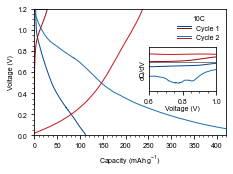

In [12]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height), nrows=1, ncols=1)

colors_blue = cm.Blues(np.linspace(0.9, 0.3, 5))[:,0:3]
colors_red  = cm.Reds( np.linspace(0.9, 0.3, 5))[:,0:3]

ax.set_xlabel('Capacity (mAh g$^{-1}$)')
ax.set_ylabel('Voltage (V)')
ax.set_xlim([0, 420])
ax.set_ylim([0, 1.2])
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax_inset0 = inset_axes(ax, width='100%', height='100%',
                       bbox_to_anchor=(0.58, 0.375, 0.35, 0.35),
                       bbox_transform=ax.transAxes,
                       loc='upper left')
ax_inset0.set_xlabel('Voltage (V)', labelpad=-0.1)
ax_inset0.set_ylabel('dQ/dV')
ax_inset0.xaxis.set_minor_locator(AutoMinorLocator())
ax_inset0.set_xlim([0.6, 1.0])
ax_inset0.set_ylim([-500, 250])
ax_inset0.get_yaxis().set_ticks([])
ax_inset0.axhline(0, color='tab:gray')


lith1 = all_data_constcurr['cellC_10C_CF3']['First lith data']
delith1 = all_data_constcurr['cellC_10C_CF3']['First delith data']
lith2 = all_data_constcurr['cellC_10C_CF3']['Second lith data']
delith2 = all_data_constcurr['cellC_10C_CF3']['Second delith data']

ax.plot(lith1[:,2], lith1[:,1], color=colors_blue[0])
ax.plot(delith1[:,2], delith1[:,1], color=colors_red[0])
ax.plot(lith2[:,2], lith2[:,1], color=colors_blue[1])
ax.plot(delith2[:,2], delith2[:,1], color=colors_red[1])

# Filter and get dQ/dV
filter_size = 101
Q_filt_lith1 = savgol_filter(lith1[:,2], filter_size, 1)
V_filt_lith1 = savgol_filter(lith1[:,1], filter_size, 1)
dQdV_lith1 = np.gradient(Q_filt_lith1, V_filt_lith1)

Q_filt_delith1 = savgol_filter(delith1[:,2], filter_size, 1)
V_filt_delith1 = savgol_filter(delith1[:,1], filter_size, 1)
dQdV_delith1 = np.gradient(Q_filt_delith1, V_filt_delith1)

Q_filt_lith2 = savgol_filter(lith2[:,2], filter_size, 1)
V_filt_lith2 = savgol_filter(lith2[:,1], filter_size, 1)
dQdV_lith2 = np.gradient(Q_filt_lith2, V_filt_lith2)

Q_filt_delith2 = savgol_filter(delith2[:,2], filter_size, 1)
V_filt_delith2 = savgol_filter(delith2[:,1], filter_size, 1)
dQdV_delith2 = np.gradient(Q_filt_delith2, V_filt_delith2)

ax_inset0.plot(V_filt_lith1, dQdV_lith1, color=colors_blue[0])
ax_inset0.plot(V_filt_delith1, dQdV_delith1, color=colors_red[0])
ax_inset0.plot(V_filt_lith2, dQdV_lith2, color=colors_blue[1])
ax_inset0.plot(V_filt_delith2, dQdV_delith2, color=colors_red[1])


ax.legend([(colors_blue[0], colors_red[0]),
            (colors_blue[1], colors_red[1])],
            ['Cycle 1', 'Cycle 2'],
            handler_map={tuple: AnyObjectHandler()},
            loc='upper right',
            title='10C')


plt.tight_layout()
plt.savefig(figpath / 'C_rate_10C.eps', bbox_inches='tight', format='eps')

## Create main plot

Create colors:

In [13]:
colors_constcurr  = cm.Blues( np.linspace(0.4, 0.9, len(all_data_constcurr.items())))[:,0:3]
colors_multistep  = cm.Purples( np.linspace(0.4, 0.9, len(all_data_multistep.items())))[:,0:3]

In [14]:
def make_legend1(ax, loc):
    ax.plot(-1, 1, 'ok', label='One-step formation')
    ax.plot(-1, 1, 'sk', label='Two-step formation')
    ax.legend(loc=loc)

/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:101: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


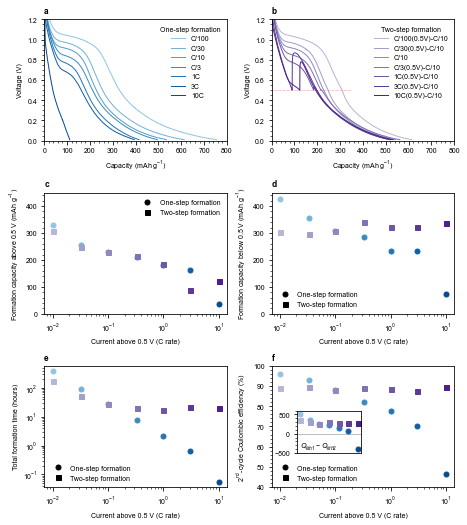

In [15]:
fig, ax = plt.subplots(figsize=(fig_width*2, fig_height*3), nrows=3, ncols=2)
ax = ax.ravel()

# Set main axes labels
for k, a in enumerate(ax):
    a.set_title(chr(97+k), loc='left', weight='bold')
    if k == 0 or k == 1:
        a.set_xlabel('Capacity (mAh g$^{-1}$)')
    else:
        a.set_xlabel('Current above 0.5 V (C rate)')
        make_legend1(a, 'lower left' if k != 2 else 'best')

ax[0].set_ylabel('Voltage (V)')
ax[1].set_ylabel('Voltage (V)')
ax[2].set_ylabel(r'Formation capacity above 0.5 V (mAh g$^{-1}$)')
ax[3].set_ylabel(r'Formation capacity below 0.5 V (mAh g$^{-1}$)')
ax[4].set_ylabel(r'Total formation time (hours)')
ax[5].set_ylabel(r'2$^{\rm nd}$-cycle Coulombic efficiency (%)')

ax_inset5 = inset_axes(ax[5], width='100%', height='100%',
                       bbox_to_anchor=(0.12, 0.31, 0.35, 0.35),
                       bbox_transform=ax[5].transAxes,
                       loc='upper left')

ax[0].set_xlim([0, 800])
ax[1].set_xlim([0, 800])
ax[0].set_ylim([0, 1.2])
ax[1].set_ylim([0, 1.2])
ax[2].set_ylim([0, 450])
ax[3].set_ylim([0, 450])
ax[5].set_ylim([40, 100])
ax_inset5.set_ylim([-501, 601])

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[3].yaxis.set_minor_locator(AutoMinorLocator())
ax[5].yaxis.set_minor_locator(AutoMinorLocator())
ax_inset5.yaxis.set_minor_locator(AutoMinorLocator())

ax[1].plot([0, 350], [0.5, 0.5], color='tab:red', lw=0.5, ls=':')
ax_inset5.axhline(0, color='tab:gray', lw=0.5)

## Constant current cycling

for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    # Extract values
    first_lith_data = value['First lith data']
    C_rate = value['C rate']
    C_rate_string = value['C rate string']
    CE_cyc2 = value['2nd cycle CE']
    Qlith_cyc1_minus_cyc2 = value['First lith - second lith']
    tlith_cyc1 = value['1st lith time']
    Qlith_cyc1_above0pt5 = value['1st lith capacity above 0.5V']
    Qlith_cyc1_below0pt5 = value['1st lith capacity below 0.5V']
    
    Q = first_lith_data[:, 2]
    V = first_lith_data[:, 1]
    
    ax[0].plot(Q, V, color=colors_constcurr[k], label=C_rate_string)
    ax[2].semilogx(C_rate, Qlith_cyc1_above0pt5, 'o', color=colors_constcurr[k])
    ax[3].semilogx(C_rate, Qlith_cyc1_below0pt5, 'o', color=colors_constcurr[k])
    ax[4].loglog(C_rate, tlith_cyc1, 'o', color=colors_constcurr[k])
    ax[5].semilogx(C_rate, CE_cyc2, 'o', color=colors_constcurr[k])
    ax_inset5.semilogx(C_rate, Qlith_cyc1_minus_cyc2, 'o', color=colors_constcurr[k])

## Multistep cycling

for k, (key, value) in enumerate(all_data_multistep.items()):
    
    # Extract values
    first_lith_data = value['First lith data']
    C_rate = value['C rate']
    C_rate_string = value['C rate string']
    CE_cyc2 = value['2nd cycle CE']
    Qlith_cyc1_minus_cyc2 = value['First lith - second lith']
    tlith_cyc1 = value['1st lith time']
    Qlith_cyc1_above0pt5 = value['1st lith capacity above 0.5V']
    Qlith_cyc1_below0pt5 = value['1st lith capacity below 0.5V']
        
    Q = first_lith_data[:, 2]
    V = first_lith_data[:, 1]
    
    ax[1].plot(Q, V, color=colors_multistep[k], label=C_rate_string)
    ax[2].semilogx(C_rate, Qlith_cyc1_above0pt5, 's', color=colors_multistep[k])
    ax[3].semilogx(C_rate, Qlith_cyc1_below0pt5, 's', color=colors_multistep[k])
    ax[4].loglog(C_rate, tlith_cyc1, 's', color=colors_multistep[k])
    ax[5].semilogx(C_rate, CE_cyc2, 's', color=colors_multistep[k])
    ax_inset5.semilogx(C_rate, Qlith_cyc1_minus_cyc2, 's', color=colors_multistep[k])

ax[0].legend(loc='upper right', title='One-step formation')
ax[1].legend(loc='upper right', title='Two-step formation')

ax_inset5.get_xaxis().set_ticks([])
ax_inset5.annotate('$Q_{lith1}-Q_{lith2}$', (0.05, 0.02), xycoords='axes fraction',
                   horizontalalignment='left', verticalalignment='bottom')

plt.tight_layout()
plt.savefig(figpath / 'C_rate.eps', bbox_inches='tight', format='eps')

## Sum of first and second cycle capacity loss

This plot shows the total capacity loss of the first and second cycle, excluding capacity >0.5 V. We also calculate the average ratio of capacity loss in the first cycle vs. the second cycle.

Average ratio of cyc1 vs. cyc2 capacity loss = 7.64


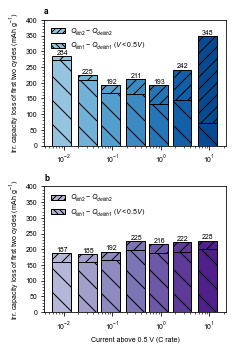

In [16]:
fig, ax = plt.subplots(figsize=(fig_width, 2*fig_height), nrows=2, sharey=True)

ax[0].set_xscale("log")
ax[1].set_xscale("log")

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

ratios = []

for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    # Extract values
    C_rate = value['C rate']
    Qlith2 = value['Second lith data'].max()
    Qdelith2 = value['Second delith data'].max()
    Qlith_cyc1_below0pt5 = value['1st lith capacity below 0.5V']
    Qdelith_cyc1_below0pt5 = value['1st delith capacity below 0.5V']
    Qlith_cyc1_plus_cyc2 = Qlith_cyc1_below0pt5 - Qdelith_cyc1_below0pt5 + Qlith2 - Qdelith2
    
    # How much larger is cycle1 capacity loss vs cycle2 capacity loss?
    cyc1_cyc2_ratio = (Qlith_cyc1_below0pt5 - Qdelith_cyc1_below0pt5) / (Qlith2 - Qdelith2)
    ratios.append(cyc1_cyc2_ratio)
    
    ax[0].bar(C_rate, Qlith_cyc1_below0pt5 - Qdelith_cyc1_below0pt5,
              C_rate / 1.2, color=colors_constcurr[k],
              hatch='\\', edgecolor='k')
    ax[0].bar(C_rate, Qlith2 - Qdelith2,
              C_rate / 1.2, color=colors_constcurr[k],
              bottom=Qlith_cyc1_below0pt5 - Qdelith_cyc1_below0pt5,
              hatch='//', edgecolor='k')
    
    ax[0].text(C_rate * 0.93, Qlith_cyc1_plus_cyc2 + 5,
               f'{Qlith_cyc1_plus_cyc2:.0f}',
               horizontalalignment='center')

## Multistep cycling

for k, (key, value) in enumerate(all_data_multistep.items()):
    
    # Extract values
    C_rate = value['C rate']
    Qlith2 = value['Second lith data'].max()
    Qdelith2 = value['Second delith data'].max()
    Qlith_cyc1_below0pt5 = value['1st lith capacity below 0.5V']
    Qdelith_cyc1_below0pt5 = value['1st delith capacity below 0.5V']
    Qlith_cyc1_plus_cyc2 = Qlith_cyc1_below0pt5 - Qdelith_cyc1_below0pt5 + Qlith2 - Qdelith2
    
    ax[1].bar(C_rate, Qlith_cyc1_below0pt5 - Qdelith_cyc1_below0pt5,
              C_rate / 1.2, color=colors_multistep[k],
              hatch='\\', edgecolor='k')
    ax[1].bar(C_rate, Qlith2 - Qdelith2,
              C_rate / 1.2, color=colors_multistep[k],
              bottom=Qlith_cyc1_below0pt5 - Qdelith_cyc1_below0pt5,
              hatch='//', edgecolor='k')
    
    ax[1].text(C_rate * 0.93, Qlith_cyc1_plus_cyc2 + 5,
               f'{Qlith_cyc1_plus_cyc2:.0f}',
               horizontalalignment='center')

ax[1].set_xlabel('Current above 0.5 V (C rate)')
ax[0].set_ylabel('Irr. capacity loss of first two cycles (mAh g$^{-1}$)')
ax[1].set_ylabel('Irr. capacity loss of first two cycles (mAh g$^{-1}$)')
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())

ax[0].set_ylim([0, 400])
ax[1].set_ylim([0, 400])

ax[0].bar(10, -10, 10, color=colors_constcurr[0], hatch=r'////', edgecolor='k', label='$Q_{lith2} - Q_{delith2}$')
ax[0].bar(10, -10, 10, color=colors_constcurr[0], hatch=r'\\\\', edgecolor='k', label='$Q_{lith1} - Q_{delith1}$ ($V<0.5 V$)')
ax[1].bar(10, -10, 10, color=colors_multistep[0], hatch=r'////', edgecolor='k', label='$Q_{lith2} - Q_{delith2}$')
ax[1].bar(10, -10, 10, color=colors_multistep[0], hatch=r'\\\\', edgecolor='k', label='$Q_{lith1} - Q_{delith1}$ ($V<0.5 V$)')
ax[0].legend(loc="upper left")
ax[1].legend(loc="upper left")

fig.tight_layout()
fig.savefig(figpath / 'C_rate_SEI.eps', bbox_inches='tight', format='eps')

print(f'Average ratio of cyc1 vs. cyc2 capacity loss = {np.mean(ratios):.2f}')

## Second-cycle V vs. Q

How does V vs. Q look for cycle 2?

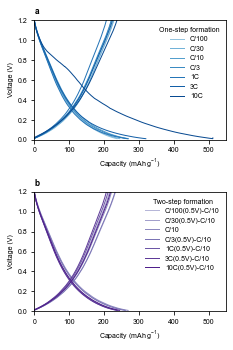

In [17]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height*2), nrows=2, ncols=1)

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

ax[0].set_xlabel('Capacity (mAh g$^{-1}$)')
ax[1].set_xlabel('Capacity (mAh g$^{-1}$)')
ax[0].set_ylabel('Voltage (V)')
ax[1].set_ylabel('Voltage (V)')

ax[0].set_xlim([0, 550])
ax[0].set_ylim([0, 1.2])
ax[1].set_xlim([0, 550])
ax[1].set_ylim([0, 1.2])

for k, (key, value) in enumerate(all_data_constcurr.items()):
    ax[0].plot(value['Second lith data'][2:, 2], value['Second lith data'][2:, 1],
            color=colors_constcurr[k], label=value['C rate string'])
    ax[0].plot(value['Second delith data'][:, 2], value['Second delith data'][:, 1],
            color=colors_constcurr[k])
    
for k, (key, value) in enumerate(all_data_multistep.items()):
    ax[1].plot(value['Second lith data'][2:, 2], value['Second lith data'][2:, 1],
            color=colors_multistep[k], label=value['C rate string'])
    ax[1].plot(value['Second delith data'][:, 2], value['Second delith data'][:, 1],
            color=colors_multistep[k])
    
ax[0].legend(loc='upper right', title='One-step formation')
ax[1].legend(loc='upper right', title='Two-step formation')

plt.tight_layout()
plt.savefig(figpath / 'C_rate_cyc2.eps', bbox_inches='tight', format='eps')

## Later-cycle CE

How does CE change at later cycle numbers?

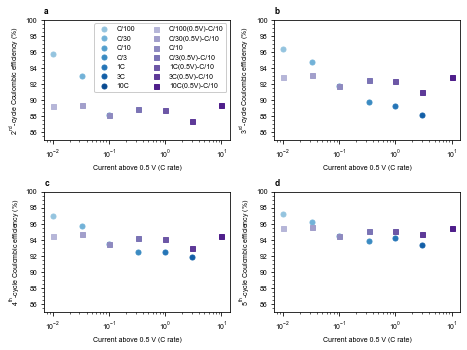

In [18]:
fig, ax = plt.subplots(figsize=(fig_width*2, fig_height*2), nrows=2, ncols=2)
ax = ax.ravel()

# Set main axes labels
for k, a in enumerate(ax):
    a.set_title(chr(97+k), loc='left', weight='bold')
    a.set_xlabel('Current above 0.5 V (C rate)')

ax[0].set_ylabel(r'2$^{\rm nd}$-cycle Coulombic efficiency (%)')
ax[1].set_ylabel(r'3$^{\rm rd}$-cycle Coulombic efficiency (%)')
ax[2].set_ylabel(r'4$^{\rm th}$-cycle Coulombic efficiency (%)')
ax[3].set_ylabel(r'5$^{\rm th}$-cycle Coulombic efficiency (%)')

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())
ax[3].yaxis.set_minor_locator(AutoMinorLocator())
ax_inset5.yaxis.set_minor_locator(AutoMinorLocator())

ax[0].set_ylim([85, 100])
ax[1].set_ylim([85, 100])
ax[2].set_ylim([85, 100])
ax[3].set_ylim([85, 100])

## Constant current cycling
for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    # Extract values
    C_rate = value['C rate']
    C_rate_string = value['C rate string']
    try:
        CE_cyc2 = value['2nd cycle CE']
        CE_cyc3 = value['3rd cycle CE']
        CE_cyc4 = value['4th cycle CE']
        CE_cyc5 = value['5th cycle CE']

        ax[0].semilogx(C_rate, CE_cyc2, 'o', color=colors_constcurr[k], label=C_rate_string)
        ax[1].semilogx(C_rate, CE_cyc3, 'o', color=colors_constcurr[k])
        ax[2].semilogx(C_rate, CE_cyc4, 'o', color=colors_constcurr[k])
        ax[3].semilogx(C_rate, CE_cyc5, 'o', color=colors_constcurr[k])
    except:
        ax[0].semilogx(C_rate, 0, 'o', color=colors_constcurr[k], label=C_rate_string)

## Multistep cycling
for k, (key, value) in enumerate(all_data_multistep.items()):
    
    # Extract values
    C_rate = value['C rate']
    C_rate_string = value['C rate string']
    CE_cyc2 = value['2nd cycle CE']
    CE_cyc3 = value['3rd cycle CE']
    CE_cyc4 = value['4th cycle CE']
    CE_cyc5 = value['5th cycle CE']
    
    ax[0].semilogx(C_rate, CE_cyc2, 's', color=colors_multistep[k], label=C_rate_string)
    ax[1].semilogx(C_rate, CE_cyc3, 's', color=colors_multistep[k])
    ax[2].semilogx(C_rate, CE_cyc4, 's', color=colors_multistep[k])
    ax[3].semilogx(C_rate, CE_cyc5, 's', color=colors_multistep[k])

ax[0].legend(frameon=True, ncol=2, framealpha=1)
    
plt.tight_layout()
plt.savefig(figpath / 'C_rate_CE.eps', bbox_inches='tight', format='eps')

## Correlation analysis and dQ/dV

Get all peaks and currents

In [19]:
V_peaks = []
currents = []

for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    if value['C rate'] < 10:

        currents.append(value['C rate'])
        V_peaks.append(value['V_peak'])
        
for k, (key, value) in enumerate(all_data_multistep.items()):
    
    if value['C rate'] < 3:

        currents.append(value['C rate'])
        V_peaks.append(value['V_peak'])

Linear fit:

In [20]:
p = np.polyfit(np.log10(currents), V_peaks, 1)
p

array([-0.14568302,  0.75880378])

## Create secondary plot

In [21]:
def make_legend2(ax, loc):
    ax.plot(-100, 1, 'ok', label='One-step formation')
    ax.plot(-100, 1, 'sk', label='Two-step formation')
    ax.legend(loc=loc)

/Users/peter/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


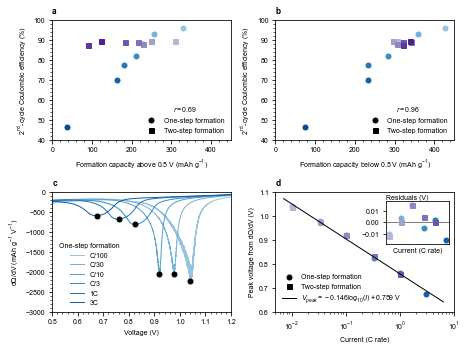

In [22]:
Qlith_cyc1_above0pt5_list = []
Qlith_cyc1_below0pt5_list = []
CE_cyc2_list = []

fig, ax = plt.subplots(figsize=(fig_width*2, fig_height*2), nrows=2, ncols=2)
ax = ax.ravel()

ax_inset3 = inset_axes(ax[3], width='100%', height='100%',
                       bbox_to_anchor=(0.6, 0.6, 0.35, 0.35),
                       bbox_transform=ax[3].transAxes,
                       loc='upper left')

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')
ax[2].set_title('c', loc='left', weight='bold')
ax[3].set_title('d', loc='left', weight='bold')
ax_inset3.set_title('Residuals (V)', loc='left', fontsize=7, pad=1.5)

ax[0].set_xlabel(r'Formation capacity above 0.5 V (mAh g$^{-1}$)')
ax[1].set_xlabel(r'Formation capacity below 0.5 V (mAh g$^{-1}$)')
ax[2].set_xlabel('Voltage (V)')
ax[3].set_xlabel('Current (C rate)')
ax[0].set_ylabel(r'2$^{\rm nd}$-cycle Coulombic efficiency (%)')
ax[1].set_ylabel(r'2$^{\rm nd}$-cycle Coulombic efficiency (%)')
ax[2].set_ylabel('dQ/dV (mAh g$^{-1}$ V$^{-1}$)')
ax[3].set_ylabel('Peak voltage from dQ/dV (V)')
ax_inset3.set_xlabel('Current (C rate)')

ax[0].set_xlim([0, 450])
ax[1].set_xlim([0, 450])
ax[2].set_xlim([0.5, 1.2])
ax[3].set_xlim([5e-3, 10])
ax[0].set_ylim([40, 100])
ax[1].set_ylim([40, 100])
ax[2].set_ylim([-3000, 0])
ax[3].set_ylim([0.6, 1.1])
ax_inset3.set_ylim([-0.018, 0.018])

ax[0].xaxis.set_minor_locator(AutoMinorLocator())
ax[1].xaxis.set_minor_locator(AutoMinorLocator())
ax[2].xaxis.set_minor_locator(AutoMinorLocator())
ax[3].xaxis.set_minor_locator(AutoMinorLocator())
ax[0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1].yaxis.set_minor_locator(AutoMinorLocator())
ax[2].yaxis.set_minor_locator(AutoMinorLocator())

ax_inset3.axhline(0, color='tab:gray')
ax_inset3.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

make_legend2(ax[0], 'lower right')
make_legend2(ax[1], 'lower right')
make_legend1(ax[3], 'upper right')


for k, (key, value) in enumerate(all_data_constcurr.items()):
    
    # Extract values
    C_rate_string = value['C rate string']
    C_rate = value['C rate']
    
    Qlith_cyc1_above0pt5_list.append(value['1st lith capacity above 0.5V'])
    Qlith_cyc1_below0pt5_list.append(value['1st lith capacity below 0.5V'])
    CE_cyc2_list.append(value['2nd cycle CE'])
    
    first_lith_data = value['First lith data']
    Q = first_lith_data[:, 2]
    V = first_lith_data[:, 1]
    
    ax[0].plot(Qlith_cyc1_above0pt5_list[-1], CE_cyc2_list[-1], 'o', color=colors_constcurr[k])
    ax[1].plot(Qlith_cyc1_below0pt5_list[-1], CE_cyc2_list[-1], 'o', color=colors_constcurr[k])
    
    # Plots
    if C_rate != 10:
        
        # Get values
        V_filt = value['V_filt']
        dQdV = value['dQdV']
        V_peak = value['V_peak']
        dQdV_peak = value['dQdV_peak']
        
        # Plot
        ax[2].plot(V_filt, dQdV, color=colors_constcurr[k], label=C_rate_string)
        ax[2].plot(V_peak, dQdV_peak, 'ok')
        ax[3].semilogx(C_rate, V_peak, 'o', color=colors_constcurr[k])
        
        residual = V_peak - (p[0] * np.log10(C_rate) + p[1])
        ax_inset3.semilogx(C_rate, residual, 'o', color=colors_constcurr[k])
    

for k, (key, value) in enumerate(all_data_multistep.items()):
    
    C_rate = value['C rate']
    
    Qlith_cyc1_above0pt5_list.append(value['1st lith capacity above 0.5V'])
    Qlith_cyc1_below0pt5_list.append(value['1st lith capacity below 0.5V'])
    CE_cyc2_list.append(value['2nd cycle CE'])
    
    ax[0].plot(Qlith_cyc1_above0pt5_list[-1], CE_cyc2_list[-1], 's', color=colors_multistep[k])
    ax[1].plot(Qlith_cyc1_below0pt5_list[-1], CE_cyc2_list[-1], 's', color=colors_multistep[k])
    
    # Plots
    if C_rate < 3:
        
        # Get values
        V_peak = value['V_peak']
        
        # Plot
        ax[3].semilogx(C_rate, V_peak, 's', color=colors_multistep[k])
        
        residual = V_peak - (p[0] * np.log10(C_rate) + p[1])
        ax_inset3.semilogx(C_rate, residual, 's', color=colors_multistep[k])
        
# Get correlations
r_above = pearsonr(Qlith_cyc1_above0pt5_list, CE_cyc2_list)[0]
r_below = pearsonr(Qlith_cyc1_below0pt5_list, CE_cyc2_list)[0]
    
ax[0].legend(title='$r=%.2f$' % r_above)
ax[1].legend(title='$r=%.2f$' % r_below, loc='lower right')
ax[2].legend(title='One-step formation', loc='lower left')

eqn_label = '$V_{peak}=%.3f' % p[0] + '\log_{10}(I) + %.3f$ V' % p[1]

# Plot linear fit
C_rate_logspace = np.logspace(-2.15, 0.8, 100)
ax[3].semilogx(C_rate_logspace, p[0]*np.log10(C_rate_logspace) + p[1],
               'k', label=eqn_label)

ax[3].legend(loc='lower left')

plt.tight_layout()
plt.savefig(figpath / 'C_rate_extras.eps', bbox_inches='tight', format='eps')

## Plot second cycle data

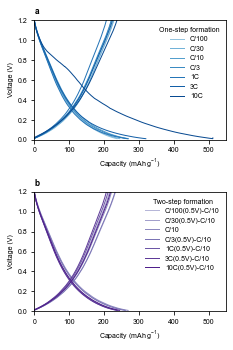

In [23]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height*2), nrows=2, ncols=1)

ax[0].set_title('a', loc='left', weight='bold')
ax[1].set_title('b', loc='left', weight='bold')

ax[0].set_xlabel('Capacity (mAh g$^{-1}$)')
ax[1].set_xlabel('Capacity (mAh g$^{-1}$)')
ax[0].set_ylabel('Voltage (V)')
ax[1].set_ylabel('Voltage (V)')

ax[0].set_xlim([0, 550])
ax[0].set_ylim([0, 1.2])
ax[1].set_xlim([0, 550])
ax[1].set_ylim([0, 1.2])

for k, (key, value) in enumerate(all_data_constcurr.items()):
    ax[0].plot(value['Second lith data'][2:, 2], value['Second lith data'][2:, 1],
            color=colors_constcurr[k], label=value['C rate string'])
    ax[0].plot(value['Second delith data'][:, 2], value['Second delith data'][:, 1],
            color=colors_constcurr[k])
    
for k, (key, value) in enumerate(all_data_multistep.items()):
    ax[1].plot(value['Second lith data'][2:, 2], value['Second lith data'][2:, 1],
            color=colors_multistep[k], label=value['C rate string'])
    ax[1].plot(value['Second delith data'][:, 2], value['Second delith data'][:, 1],
            color=colors_multistep[k])
    
ax[0].legend(loc='upper right', title='One-step formation')
ax[1].legend(loc='upper right', title='Two-step formation')

plt.tight_layout()
plt.savefig(figpath / 'C_rate_cyc2.eps', bbox_inches='tight', format='eps')